# Feature Extraction ANIMATION





In [1]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
#
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import librosa
try:
  import pyspch
except:
  ! pip install git+https://github.com/compi1234/pyspch.git
import pyspch.spg as Sps
import pyspch.audio as Spa
import pyspch.utils as Spu
import pyspch.io.timit as Spio
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyspch.display as Spd
import scipy.fft as fft

# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### Load a Data File and segmentation if available

In [2]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
name = 'misc/bad_bead_booed'
#name ='misc/b_8k'
name = 'misc/friendly'
#name = 'timit/si1027'
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = Spa.load(wavfname)
if sr > 16000:
    wavdata, sr = Spa.load(wavfname,sample_rate=16000) 

# get segmentations and convert TIMIT segmentations from sample indices to time, plus map from the TIMIT61 alphabet to CMU
dsegt = 1.
xlat = None
if name.split('/')[0] == 'timit':
    dsegt = 1./16000.
    xlat = 'map61_cmu'
    
# try to find a segmentation, grapheme or phoneme or word
seg = Spio.read_seg_file(dir+name+ ".gra",dt=dsegt,fmt='float32')
if seg is None: seg = Spio.read_seg_file(dir+name+ ".phn",dt=dsegt,fmt='float32',xlat=xlat)
if seg is None: seg = Spio.read_seg_file(dir+name+ ".wrd",dt=dsegt,fmt='float32')

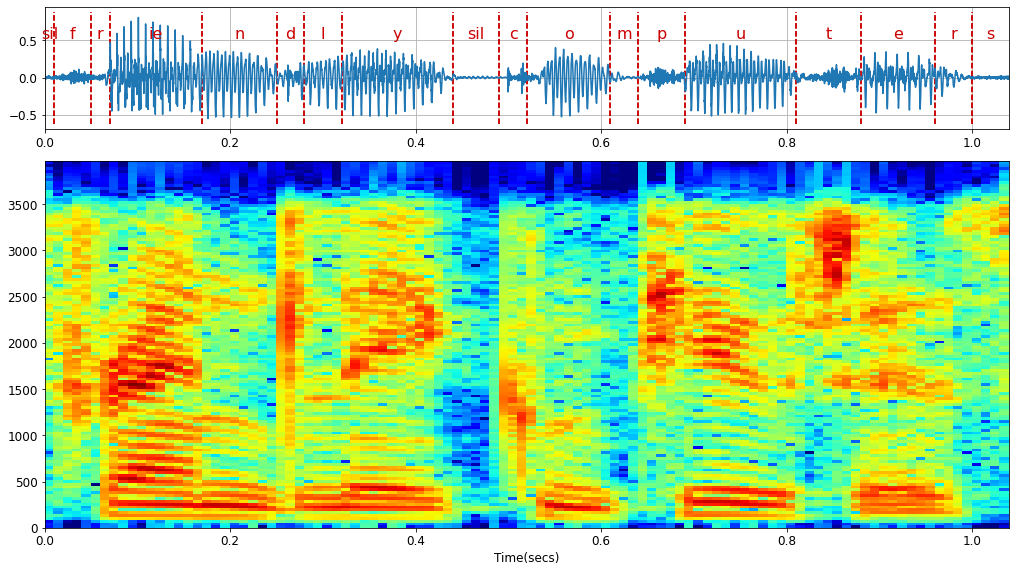

In [3]:
# compute a spectrogram as starting point for further analysis
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None)
(nparam,nfr)=spg.shape
d_freq = sr/(2.*(nparam-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spg,segwav=seg,sample_rate=sr,figsize=(14,8))
fig

### Feature Extraction

From Spectrogram to Features

While a spectrogram is already a much more appealing representation than the raw speech waveform, we may still want to apply some FEATURE EXTRACTION on the spectrogram with as main purpose to present relevant information to the recognizer and to suppress disturbing, noisy side information at the same time

For the Feature Extraction we stick to a frame synchronous approach.  However, the features extracted at frame 'i' may well derive their information from many frames around 'i', e.g. in the case below the feature extraction spans 2N+1 frames

$$
\underbrace{ S_{i-N} \hspace{0.5cm} ... \text{  } S_i ... \hspace{0.5cm} S_{i+N} }_{F_i}
$$

A few common examples of feature extraction:

1. Cepstra   
This is a single frame operation in which the cepstrum is computed of low dimensional representation of spectral envelope

2. Cepstra + Delta-Cepstra   
The "delta-cepstrum" is added to the feature vector, to add "trend" to the instantaneous spectral information .
It may be computed as simple first order difference over time
$$
\Delta c_i = c_{i+1}-c_{i-1}
$$
3. Mean Normalization   



In [10]:
# returns the non truncated cepstrum if ncep is None, otherwise the truncated cepstrum
def cepstrum(spg,ncep=13):
    cep = fft.dct(spg,axis=0,type=3)
    if ncep is None:    return(cep)
    else: 
        return(cep[0:ncep,:])

def mean_norm(ftrs):
    ftrs_norm = (ftrs - ftrs.mean(axis=1,keepdims=True))
    return(ftrs_norm)

def melcepstrum(spg,ncep=13,nmel=80,sample_rate=8000):
    spgmel = Sps.spg2mel(spg,sample_rate=sample_rate,n_mels=nmel)
    cep = fft.dct(spgmel,axis=0,type=3,norm='ortho')
    if ncep is None:    return(cep)
    else: return(cep[0:ncep,:])
    
# returns evelope and residue spectra from cepstrum
# cep will first be padded to size 'nspec' before applying the dct
def cepstrum_inv(cep,ncep=13,nspec=128):
    if cep.shape[0] > cep.shape[0]:
        cep = np.vstack( (cep,np.zeros((nspec-cep.shape[0],cep.shape[1]))) )
    else:
        cep = cep[0:nspec,:]
    cep_t = np.zeros((nspec,cep.shape[1]))
    cep_t[0:ncep,:] = cep[0:ncep,:]
    #if cep.shape[0] > nspec : cep = cep[0:nspec,:]

    env = fft.idct(cep_t,axis=0,type=3)
    res = fft.idct(cep - cep_t,axis=0,type=3)
    return(env,res)


def feature_extraction(wavdata=None, spg=None,n_mels=80,sample_rate=8000,ncep=13,Deltas=True,Norm=None):
    #1. Spectral Estimation (Fourier Spectrogram)
    if spg is None:
        spg = Sps.spectrogram(wavdata,sample_rate=sample_rate,n_mels=None)
    
    #2. Mel scale transform
    if n_mels is not None:
        spg1 = Sps.spg2mel(spg,n_mels=n_mels,sample_rate=sample_rate)
    else: spg1 = spg
        
    #3. Cepstral transform
    if ncep is None: ftr1 = spg1
    else: ftr1 = cepstrum(spg1,ncep=ncep)
        
    #4. Add delta's
    if Deltas:
        deltas = librosa.feature.delta(ftr1,order=1)
        ftrs = np.vstack((ftr1,deltas))
    else: ftrs = ftr1
        
    #5. Mean and variance normalization
    if Norm is None:
        ftrs_n = ftrs
    elif Norm == "mean":
        ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )
    elif Norm == "meanvar":
        ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)        

    return(ftrs_n)    

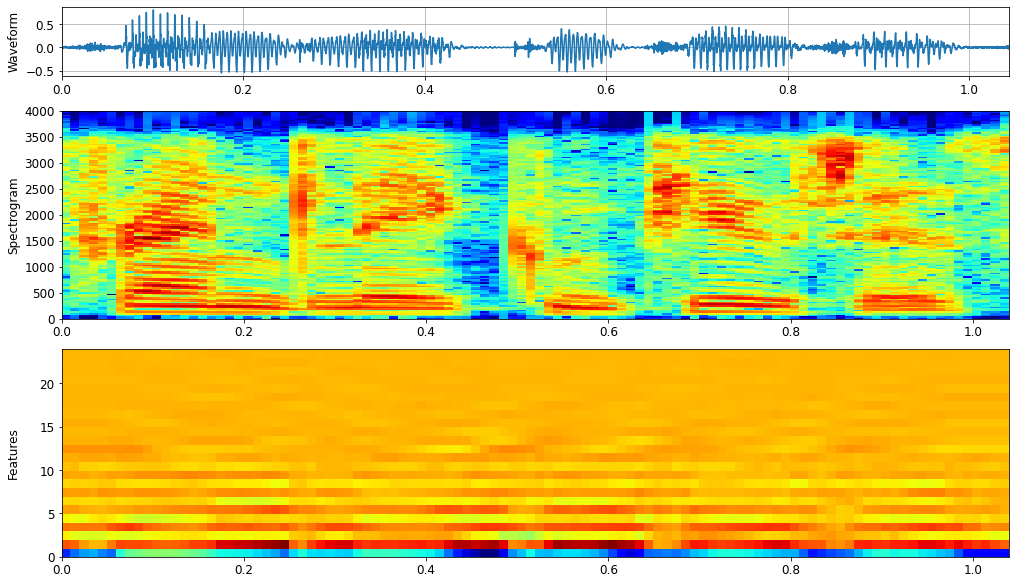

In [17]:
def make_fig1(wavdata,spg,ftrs,sr=8000.,seg=None):
    pos = iframe*shift
    fig = Spd.SpchFig(row_heights=[1,3,3],figsize=(14,8))
    fig.add_line_plot(wavdata, iax = 0,dx=1/sr,ylabel='Waveform')
    fig.add_img_plot(spg, iax=1,dx=shift,dy=sr/(2.*spg.shape[0]),ylabel='Spectrogram')
    fig.add_img_plot(ftrs, iax=2,dx=shift,ylabel='Features')
    if seg is not None:
        fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)
    return(fig)

spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
ftrs = feature_extraction(spg=spg,n_mels=20,ncep=12,Deltas=True,Norm=None)
fig = make_fig1(wavdata,spg,ftrs)
display(fig)

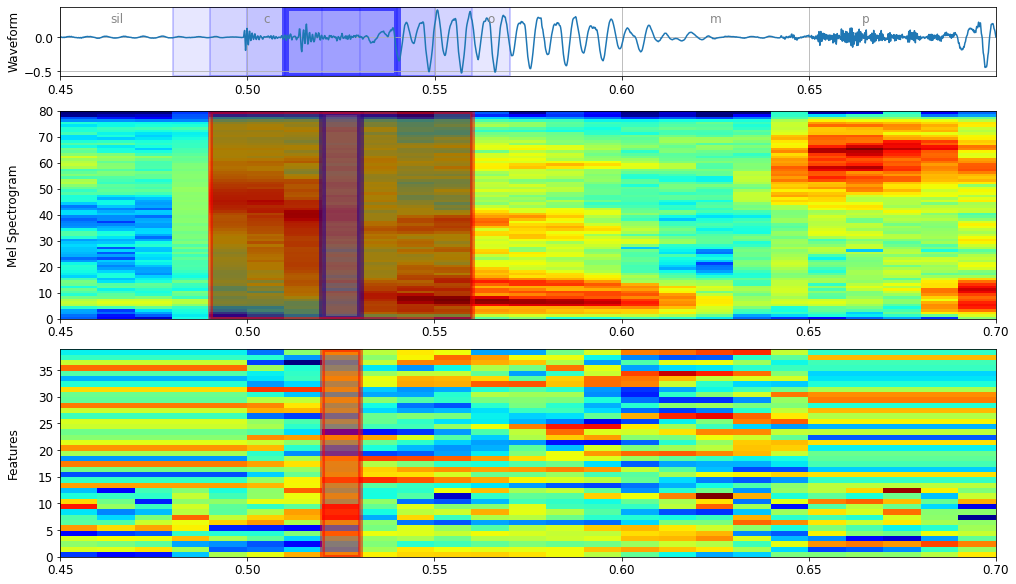

In [5]:
    
frames = [45,70]
n_mel = 80
n_cep = 13
width = 3
iframe = 50
pos = iframe*shift
wav1 = wavdata[frames[0]*n_shift:frames[1]*n_shift]

spgmel = Sps.spectrogram(wav1,sample_rate=sr,n_mels=n_mel)
mfcc = librosa.feature.mfcc(S=spgmel,sr=sr,n_mfcc=n_cep,dct_type=3)
mfcc_delta = librosa.feature.delta(mfcc,order=1)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# creates a feature vector that stacks mfcc;2, delta's and double delta's
ftrs = np.vstack((mfcc,mfcc_delta,mfcc_delta2))
# mean and variance normalization
ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)

def fig_feature_extraction(iframe=iframe):
    pos = iframe*shift
    fig = Spd.SpchFig(row_heights=[1,3,3],figsize=(14,8))
    fig.add_line_plot(wav1, iax = 0,dx=1/sr,x0=frames[0]*n_shift/sr,ylabel='Waveform')
    fig.add_img_plot(spgmel, iax=1,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Mel Spectrogram')
    fig.add_img_plot(ftrs_n, iax=2,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Features')
    fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)

    for i in range(-width,width+1):
        x0 = pos + (i-1) * shift
        fig.axes[0].axvspan(x0,x0+.03, color='#88F',alpha=.2,ec='b',lw=2.)    
    fig.axes[0].axvspan(pos-shift,pos+2.*shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos,pos+shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos-width*shift,pos+(width+1)*shift, color='#600',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    fig.axes[2].axvspan(pos,pos+shift, color='#F00',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    return(fig)


fig=fig_feature_extraction(iframe=52)
display(fig)

In [20]:
import ffmpeg
help(ffmpeg)

ModuleNotFoundError: No module named 'ffmpeg'

In [5]:
fig.savefig('test1')

In [6]:
for ifr in range (45,65):
    fig = fig_feature_extraction(iframe=ifr)
    fig.savefig('computer_fr%d' %ifr)
    clear_output(wait=True)

In [ ]:
w=interactive(fig_feature_extraction,iframe=widgets.IntSlider(min=frames[0],max=frames[1],value=50,
            description='Frame',layout=widgets.Layout(width='10in'))
             );
w

In [ ]:
frames = [40,60]
n_mel = 24
n_cep = 13
mel80 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=n_mel)
mfcc = librosa.feature.mfcc(S=mel80,sr=sr,n_mfcc=n_cep,dct_type=3)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
ftrs = np.vstack((mfcc,mfcc_delta,mfcc_delta2))
# mean and variance normalization
ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mfcc,ftrs_n], img_labels=['mel spectrogram','mfcc features','mfcc + delta\'s\nnormalized'])
fig.axes[3].set_yticks(np.arange(0,n_cep,2)+0.5)
fig.axes[3].set_yticklabels(np.arange(0,n_cep,2))
fig.axes[4].set_yticks(np.arange(0,n_cep,2)+0.5)
fig.axes[4].set_yticklabels(np.arange(0,n_cep,2))

fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)
display(fig)

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
def icepstrum(iframe,melFB,ncep):
    times=[iframe*shift,(iframe+1)*shift]
    itimes=[(iframe-1)*n_shift,(iframe+2)*n_shift]
    fig = Spd.SpchFig(col_widths=[3,1],row_heights=[1,3,3,3,3],figsize=(14,8))
    cep = cepstrum(spg,ncep=None)
    [env,res]=cepstrum_inv(cep,ncep=ncep,nspec=cep.shape[0])
    fig.add_line_plot(wavdata, iax = [0,0],dx=1/sr)
    fig.add_line_plot(wavdata[itimes[0]:itimes[1]],iax=[0,1],dx=1/sr,x0=itimes[0]/sr)
    fig.add_img_plot(spg, iax=[1,0],dx=shift)
    fig.add_line_plot(spg[:,iframe],iax=[1,1])
    fig.add_img_plot(cep, iax=[2,0],dx=shift,ylabel='Cepstrum')
    fig.add_line_plot(cep[:,iframe],iax=[2,1])
    fig.add_img_plot(env, iax=[3,0],dx=shift,ylabel='Envelope')
    fig.add_line_plot(env[:,iframe],iax=[3,1])
    fig.add_img_plot(res, iax=[4,0],dx=shift,ylabel='Residue')
    fig.add_line_plot(res[:,iframe],iax=[4,1])
    display(fig)

w=interactive(icepstrum,iframe=widgets.IntSlider(min=1,max=(nfr-2),value=nfr/2,
            description='Frame',layout=widgets.Layout(width='8in')),
            ncep=widgets.IntSlider(min=1,max=128,value=13,
                        description='#cep',layout=widgets.Layout(width='4in'))
             );
w

#self.wg_melfb = widgets.Checkbox(value=self.melfb,description='Mel Filterbank',indent=True,style=dw_0)
#        self.wg_nmels = widgets.IntSlider(value=self.nmels,min=10,max=128,step=1,description="#b",style=dw_3)

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
cep = cepstrum(spg,ncep=13)

In [ ]:
cep1= np.vstack((cep,np.zeros((115,cep.shape[1]))))
cep1.shape

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
cep = cepstrum(spg,ncep=None)
[env,res]=cepstrum_inv(cep,ncep=20,nspec=129)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=None,sample_rate=sr,figsize=(15,10),
                img_ftrs=[cep[1:,:],env,res], img_labels=['cep','env','res'])
fig

In [ ]:
nmel =80
ncep = 80

spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=nmel)
mfcc_1 = librosa.feature.mfcc(S=spgmel,sr=sr,n_mfcc=ncep,dct_type=3)
mfcc_2 = cepstrum(spgmel,ncep=ncep,sample_rate=sr)

In [ ]:
print(mfcc_1.shape, mfcc_2.shape)
fig,ax = plt.subplots(3,1)
ax[0].plot(mfcc_1[:,10])
ax[1].plot(mfcc_2[:,10]/13)
ax[2].plot(mfcc_1[:,10] - mfcc_2[:,10]/13)

In [ ]:
cep1 = cepstrum(spg,ncep=12)
cep1.shape

In [ ]:
cep2 = np.pad(cep1,((0,8),(0,0)))
cep1[:,0:3],cep2[:,0:3]

In [ ]:

ifr = 10
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
print(spg.shape)
fr1 = spg[:,ifr]
fr1_idct = fft.idct(fr1,type=3)
fr1_did = fft.dct(fr1_idct,type=3)
fr1, fr1_did
fig,ax=plt.subplots(1,2)
fig.axes[0].plot(spg[0,:])
fig.axes[1].plot(spg[128,:])

In [ ]:
import scipy.fft as fft
ifr=10
nmel=None
ncep=25
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
if nmel is None: spg2 =spg
else: spg2 = Sps.spg2mel(spg,sample_rate=sr,n_mels=nmel)
spg_idct = fft.idct(spg2,axis=0,type=3)
cep = np.zeros(spg_idct.shape)
cep[0:ncep,:]=spg_idct[0:ncep,:]
cepres = np.zeros(spg_idct.shape)
cepres[ncep:,:]=spg_idct[ncep:,:]
env = fft.dct(cep,axis=0,type=3)
res = fft.dct(cepres,axis=0,type=3)
#fig,ax=plt.subplots(4,1)
#fig.axes[0].plot(spg_in[:,10])
#fig.axes[1].plot(spg_idct[:,10])
#fig.axes[2].plot(cep_rec[:,10])
#fig.axes[3].plot(res_rec[:,10])
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=None,sample_rate=sr,figsize=(15,10),
                img_ftrs=[cep,env,res], img_labels=['cep','env','res'])
fig

In [ ]:

nmel = 80
ncep = 10
frames = [48,102]
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=nmel)
mfcc_1 = mfcc[0:ncep,:]
mfcc_2 = mfcc[ncep:,:]
mel_env = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_1, n_mels=nmel,dct_type=2) )
mel_res = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_2, n_mels=nmel,dct_type=2) )
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mel_env,mel_res], img_labels=['mel spectrum','envelope','residue'])
fig

In [ ]:
nmel = 80
ncep = 10
frames = [48,102]
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=nmel)
mfcc = librosa.feature.mfcc(S=mel80,sr=sr,n_mfcc=nmel,dct_type=2)
mfcc_1 = mfcc[0:ncep,:]
mfcc_2 = mfcc[ncep:,:]
mel_env = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_1, n_mels=nmel,dct_type=2) )
mel_res = librosa.power_to_db(
    librosa.feature.inverse.mfcc_to_mel(mfcc_2, n_mels=nmel,dct_type=2) )
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mel_env,mel_res], img_labels=['mel spectrum','envelope','residue'])
fig

In [ ]:
fig,ax = plt.subplots(1,2)
ifr=10
fig.axes[0].plot(mel80[:,ifr])
ax[1].plot(mel80_i[:,ifr])

In [ ]:
def box_layout(width='',padding='1px',margin='1px',border='solid 1px black'):
     return Layout(
        border= border,
        padding = padding,
        margin=   margin,
        width = width
        # margin = '1px 1px 1px 1px', white space around the outside
        # padding='2px 2px 2px 2px',   # padding = white space inside; top, right, bottom, left
     )
def pad_box_layout():
     return Layout(
        # margin='1px 1px 1px 1px', 
        padding='2px 2px 2px 2px'   # top, right, bottom, left
     )

dw_5 = {'description_width': '50%'}
dw_4 = {'description_width': '40%'}
dw_3 = {'description_width': '30%'}
dw_2 = {'description_width': '20%'}
dw_0 = {'description_width': '0%'}

class iSpectrogram2(VBox):
    def __init__(self,dpi=100,figwidth=12.,size='100%',
                root='https://homes.esat.kuleuven.be/~spchlab/data/',
                fname='misc/friendly.wav'):
        super().__init__()
        self.sample_rate = 1
        self.shift = 0.01
        self.length = 0.03
        self.preemp = 0.97
        self.nmels = 40
        self.melfb = False
        self.nmfcc = 12
        self.mfcc = False
        self.wavdata = None
        self.root = root
        self.fname = fname
        self.segfname = None
        self.wavtimes = [0., 1.]
        self.seltimes = self.wavtimes 
        self.frames = [0, 1]
        self.frame = 0
        self.spg = None
        self.spgmel = None
        self.nparam = 0
        self.nfr = 0
        self.autoplay = False
        self.dpi = dpi
        self.figwidth = figwidth
        #self.layout.width = size
        self.fig_ratio = .66
        self.fig_range = None
        self.fig_main = None
        self.fig_rhs = None

        # spectrogram controls
        self.wg_fshift = widgets.FloatSlider(value=self.shift,min=0.005,max=0.050,step=0.005,description="Shift(msec)",readout_format='.3f',style=dw_3)
        self.wg_flength = widgets.FloatSlider(value=self.length,min=0.005,max=0.200,step=0.005,description="Length(msec)",readout_format='.3f',style=dw_3)
        self.wg_preemp = widgets.FloatSlider(value=self.preemp,min=0.0,max=1.0,step=0.01,description="Preemphasis",style=dw_3)
        self.wg_melfb = widgets.Checkbox(value=self.melfb,description='Mel Filterbank',indent=True,style=dw_0)
        self.wg_nmels = widgets.IntSlider(value=self.nmels,min=10,max=128,step=1,description="#b",style=dw_3)
        self.wg_mfcc = widgets.Checkbox(value=self.mfcc,description='MFFCs',indent=True,style=dw_0)
        self.wg_nmfcc = widgets.IntSlider(value=self.nmfcc,min=5,max=128,step=1,description="#c",style=dw_3)
        self.wg_melfb.layout.width='30%'
        self.wg_nmels.layout.width='70%'
        self.wg_mfcc.layout.width='30%'
        self.wg_nmfcc.layout.width='70%'
        self.wg_fshift.observe(self.fshift_observe,'value')
        self.wg_flength.observe(self.flength_observe,'value')
        self.wg_preemp.observe(self.preemp_observe,'value')        
        self.wg_nmels.observe(self.nmels_observe,'value')
        self.wg_melfb.observe(self.melfb_observe, 'value') 
        self.wg_nmfcc.observe(self.nmfcc_observe,'value')
        self.wg_mfcc.observe(self.mfcc_observe, 'value') 
        self.controls = VBox([ self.wg_fshift,self.wg_flength,self.wg_preemp, 
                               HBox([self.wg_melfb, self.wg_nmels]), 
                               HBox([self.wg_mfcc, self.wg_nmfcc]) ] ,
                               layout=box_layout(width='50%') ) 
        #self.controls.width = '50%'
        
        # file controls
        self.audio_controls = widgets.Output()
        self.wg_root = widgets.Text(value=self.root,description="Root Dir: ",style=dw_2,continuous_update=False,layout=Layout(width='98%'))
        self.wg_root.observe(self.root_observe,'value') 
        self.wg_fname = widgets.Text(value=self.fname,description="Wav File: ",style=dw_2,continuous_update=False,layout=Layout(width='98%'))
        self.wg_fname.observe(self.fname_observe,'value') 
        self.wg_segfname = widgets.Text(value=self.segfname,description="Seg File: ",style=dw_2,continuous_update=False,layout=Layout(width='98%'))
        self.wg_segfname.observe(self.segfname_observe,'value')         
        self.file_controls = VBox( [  self.wg_root, self.wg_fname, self.wg_segfname, self.audio_controls] ,
                                  layout=box_layout(width='50%'))
        #self.file_controls.width = '30%'
        
        # slider and audio controls 
        self.wg_range = widgets.FloatSlider(value=self.frame,step=self.shift,
                            min=self.wavtimes[0],max=self.wavtimes[1],
                            description='',continuous_update=True,readout=False,
                            layout = box_layout(width=str(100.*self.fig_ratio)+"%" ,padding='0px 2px 0px 4%') )

        self.wg_range.observe(self.range_observe,'value')
        self.slider_controls = self.wg_range
        #VBox([self.wg_range],  layout = Layout(width=str(100.*self.fig_ratio)+"%" ,padding='0px 0% 0px 8%',margin='3px 3px 3px 3px')) )

                
        # Main and log Outputs: 
        self.out = widgets.Output( layout=Layout(width=str(100.*self.fig_ratio)+"%") )
        #            display( Box( self.fig_main  , layout=Layout(width='100%',padding='0px 0% 0px 0%',margin='0px 0px 0px 0px',border='solid 1px black')) )
        self.out2 = widgets.Output( layout=Layout(width=str(100.-100.*self.fig_ratio)+"%") )
        self.logscr = widgets.Output()

        # putting it all together
        self.children =  [ VBox([ HBox([  self.out, self.out2 ] ), self.slider_controls ], layout=box_layout()),
                          HBox([   self.controls,  self.file_controls ]  ), 
                           self.logscr ]
        
        self.wav_update()
        self.update()
  
    def wav_update(self):
        self.wavdata, self.sample_rate = audio.load(self.root+self.fname)  
        self.wavtimes = [0., len(self.wavdata)*(1./self.sample_rate)]
        self.frames = [0, int(self.wavtimes[1]/self.shift)]
        self.wg_range.min = self.wavtimes[0]
        self.wg_range.max = self.wavtimes[1]
        
        self.wg_range.value = (self.wavtimes[1]+self.wavtimes[0])/2
        self.frame = int(self.wg_range.value/self.shift)
        self.seltimes = self.wavtimes

        self.fig_range = spchd.PlotWaveform(self.wavdata,sample_rate=self.sample_rate,ylabel=None,xlabel=None,xticks=False,
                        figsize=(self.figwidth,0.1*self.figwidth),dpi=self.dpi)       
        
    def update(self):     
        if self.length < 0.002: self.length=0.002
        if self.shift > self.length: self.shift = self.length
        self.nshift = int(self.shift*self.sample_rate)
        
        self.frame = int(self.seltime/self.shift)
        nextend = int((self.length-self.shift)*self.sample_rate/2)

        self.seltimes = [self.frame*self.shift, (self.frame+1)*self.shift]
        self.selsamples = [self.frame*self.nshift, (self.frame+1)*self.nshift]
        self.winsamples = [self.selsamples[0]-nextend, self.selsamples[1]+nextend]
        self.wintimes = [self.winsamples[0]/self.sample_rate, self.winsamples[1]/self.sample_rate]
        
        self.spg = specg.spectrogram(self.wavdata,sample_rate=self.sample_rate,f_shift=self.shift,f_length=self.length,preemp=self.preemp,n_mels=None)
        self.spgmel = specg.spg2mel(self.spg,sample_rate=self.sample_rate,n_mels=self.nmels)
        (self.nparam,self.nfr) = self.spg.shape
        img_ftrs = []
        img_labels = []
        segs = []
        # add melfilterbank view
        if self.melfb:
            img_ftrs += [self.spgmel]
            img_labels += ['mel '+str(self.nmels)]
        # add mel cepstral view
        if self.mfcc:
            mfccs = librosa.feature.mfcc(S=self.spgmel,sr=self.sample_rate,n_mfcc=self.nmfcc,dct_type=3) 
            img_ftrs += [ mfccs ]
            img_labels += ['mfcc '+str(mfccs.shape[0])]
        # add segmentation
        try:
            seg1= tio.read_seg_file(self.root+self.segfname)
            segs = [seg1] if seg1 is not None else []
        except:
            segs = []
   
        self.fig_main = spchd.PlotSpgFtrs(spgdata=self.spg,wavdata=self.wavdata,sample_rate=self.sample_rate,shift=self.shift,
                    dy=self.sample_rate/(2*(self.nparam-1)),img_ftrs=img_ftrs,img_labels=img_labels,
                    figsize=(self.figwidth,0.5*self.figwidth),dpi=self.dpi)
        for seg in segs:
            self.fig_main.add_seg_plot(seg,iax=0,ypos=0.85,color="#444",size=12)
            self.fig_main.add_seg_plot(seg,iax=1,ypos=None,color="#222")
        
        self.fig_main.add_vrect(self.seltimes[0],self.seltimes[1],iax=0,color='#F22')
        self.fig_main.add_vrect(self.wintimes[0],self.wintimes[1],iax=0,color='#2F2')
        self.fig_main.add_vrect(self.seltimes[0],self.seltimes[1],iax=1,color='#222')
        for i in range(len(img_ftrs)):
            self.fig_main.add_vrect(self.seltimes[0],self.seltimes[1],iax=i+2,color='#222')
            
        self.plot_rhs(img_ftrs,img_labels)
            
        with self.out:
            clear_output(wait=True)

            display(self.fig_main)
            
        with self.out2:
            clear_output(wait=True)
            display(self.fig_rhs)
            
        with self.audio_controls:
            clear_output(wait=True)
            #sample_range = [int(self.seltimes[0]*self.sample_rate),int(self.seltimes[1]*self.sample_rate)]
            display(Audio(data=self.wavdata,rate=self.sample_rate,autoplay=self.autoplay))

    def plot_rhs(self,ftrs,labels):
        nftrs=0 if ftrs is None else len(ftrs)
        self.fig_rhs = spchd.SpchFig(row_heights=[1.,3.]+nftrs*[3.],figsize=((1.-self.fig_ratio)*self.figwidth,0.5*self.figwidth),dpi=self.dpi)
        sample_range = np.arange(self.winsamples[0],self.winsamples[1])
        self.fig_rhs.add_line_plot(self.wavdata[sample_range],iax=0,x=sample_range/self.sample_rate,color='#3F3',yrange=self.fig_main.axes[0].get_ylim())
        sample_range = np.arange(self.selsamples[0],self.selsamples[1])
        self.fig_rhs.axes[0].plot(sample_range/self.sample_rate,self.wavdata[self.selsamples[0]:self.selsamples[1]],color='#F00')
        self.fig_rhs.add_line_plot(self.spg[:,self.frame],iax=1,xlabel='Freq (Hz) ',dx=self.sample_rate/(2.*(self.nparam-1)))
        for i in range(nftrs):
            self.fig_rhs.add_line_plot(ftrs[i][:,self.frame],iax=i+2,xlabel=labels[i])
        plt.close(self.fig_rhs)
        return()

    def root_observe(self,change):
        self.root=change.new
        
    def fname_observe(self,change):
        self.fname=change.new
        self.wav_update()
        self.update()
        
    def segfname_observe(self,change):
        self.segfname=change.new
        self.update()
        
    def autoplay_observe(self,change):
        self.autoplay = change.new
        
    def fshift_observe(self,change):
        self.shift = change.new
        self.wg_range.step = change.new
        self.update()
        
    def flength_observe(self,change):
        self.length = change.new
        self.update()
        
    def preemp_observe(self,change):
        self.preemp = change.new
        self.update()

    def nmels_observe(self,change):
        self.nmels = change.new
        self.update()
    
    def melfb_observe(self,obj):
        self.melfb = obj.new
        self.update()
        
    def nmfcc_observe(self,change):
        self.nmfcc = change.new
        self.update()
    
    def mfcc_observe(self,obj):
        self.mfcc = obj.new
        self.update()
       
    def range_observe(self,change):
        #self.seltimes = change.new
        self.seltime = self.wg_range.value
        self.update()

In [ ]:
iSpectrogram2(dpi=80,figwidth=8)                 